<a href="https://colab.research.google.com/github/ehsanbarkhordar/Bank-Customer-Clustering-By-Transactions/blob/main/Czech_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
from numpy import array
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Input, Embedding, TimeDistributed, Dropout, Bidirectional, Concatenate
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow import feature_column
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [7]:
from os import listdir
from os.path import isfile, join
dataset_path='/content/gdrive/MyDrive/lpetrocelli-retail-banking-demo-data/'
onlyfiles = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
onlyfiles

['CRM Call Center Logs.csv',
 'CRM Events.csv',
 'completedcard.csv',
 'LuxuryLoanPortfolio.csv',
 'completedorder.csv',
 'completedloan.csv',
 'completedclient.csv',
 'completedacct.csv',
 'completedtrans.csv',
 'completeddistrict.csv',
 'CRM Reviews.csv',
 'completeddisposition.csv']

In [8]:
# Import Clients
df_clients = pd.read_csv(dataset_path+'completedclient.csv', index_col=[0], low_memory=False)
# Import Transactions
df_trans = pd.read_csv(dataset_path+'completedtrans.csv', index_col=[0], low_memory=False)
# Import Positions
df_positions = pd.read_csv(dataset_path+'completeddisposition.csv', index_col=[0], low_memory=False)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
df_clients = df_clients.join(df_positions.set_index('client_id'), on='client_id')

In [10]:
df_clients

,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id,account_id,type
client_id,,,,,,,,,,,,,,,,,,,,
C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18,A00000001,Owner
C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1,A00000002,Owner
C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1,A00000002,User
C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5,A00000003,Owner
C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5,A00000003,User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1,A00011349,Owner
C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1,A00011349,User
C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61,A00011359,Owner


In [81]:
df_clients[['account_id','sex','age','zipcode']]

,account_id,sex,age,zipcode
client_id,,,,
C00000001,A00000001,Female,29,47246
C00000002,A00000002,Male,54,10040
C00000003,A00000002,Female,59,10162
C00000004,A00000003,Male,43,49047
C00000005,A00000003,Female,39,40852
...,...,...,...,...
C00013955,A00011349,Female,54,10121
C00013956,A00011349,Male,56,10118
C00013968,A00011359,Male,31,2721


In [82]:
zip_set=set(df_clients['zipcode'])
zip_list=list(df_clients['zipcode'])
print("all zip codes in dataset: ",len(zip_list))
print("unique zip codes in dataset: ",len(zip_set))

all zip codes in dataset:  5369
unique zip codes in dataset:  3512


In [91]:
df_clients_onehot = pd.DataFrame()

In [92]:
df_clients_onehot['account_id']=df_clients['account_id']

In [93]:
# # encode sex to binary
# sex_dict={'Female': ,'Male':1}
# df_clients_onehot = pd.DataFrame()
# df_clients_onehot['sex'] = df_clients['sex'].apply(lambda x: [sex_dict.get(x)])

In [94]:
data=list(df_clients['sex'])
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of sex onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['sex'] = onehot_encoded.tolist()

['Female' 'Male' 'Female' ... 'Male' 'Female' 'Female']
[0 1 0 ... 1 0 0]
shape of sex onehot_encoded:  (5369, 2)


In [95]:
data=list(df_clients['age'])
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of age onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['age'] = onehot_encoded.tolist()

[29 54 59 ... 31 37 46]
[17 42 47 ... 19 25 34]
shape of age onehot_encoded:  (5369, 77)


In [96]:
data=list(df_clients['zipcode'])
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of zipcode onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['zipcode'] = onehot_encoded.tolist()

[47246 10040 10162 ...  2721 48475 44244]
[2625  167  211 ...  118 3049 1677]
shape of zipcode onehot_encoded:  (5369, 3512)


In [103]:
df_clients_onehot['static_vecotr'] = df_clients_onehot.apply (lambda row: np.concatenate([row.sex, row.age, row.zipcode]), axis=1

In [111]:
print("static vector dimention: ",df_clients_onehot.iloc[0]['static_vecotr'].shape)

static vector dimention:  (3591,)


In [ ]:
zip_count=len(list(df_full_client['zipcode']))
zip_unique_count=len(set(df_full_client['zipcode']))

zip_set:  3512
zip_list:  5369


In [ ]:
dic_zip={}
reveres_dic_zip={}
for i,j in enumerate(zip_set):
  dic_zip[i]=j
  reveres_dic_zip[j]=i


In [ ]:
l = []
for i in range(len(df_full_client['zipcode'])):
   l.append([reveres_dic_zip[df_full_client['zipcode'][i]]])

In [ ]:
np.array(l).shape
# input for embeding

(5369, 1)

In [ ]:
one_hot_zip=np.zeros((zip_count,len(dic_zip)))
for i in range(len(one_hot_zip)):
  one_hot_zip [i,reveres_dic_zip[df_full_client['zipcode'][i]]] = 1

In [ ]:
np.argmax(one_hot_zip[0])

2527

In [ ]:
one_hot_zip.shape

(5369, 3512)

In [ ]:
df_client_normalized=(df_full_client-df_full_client.mean())/df_full_client.std()

In [ ]:
df_client_normalized[['sex','age','zipcode']].to_numpy()

array([[-1.01472945, -0.9771898 ,  0.77112767],
       [ 0.98530081,  0.46898042, -1.3170255 ],
       [-1.01472945,  0.75821447, -1.31017836],
       ...,
       [ 0.98530081, -0.86149618, -1.72779776],
       [-1.01472945, -0.51441533,  0.84010419],
       [-1.01472945,  0.00620595,  0.60264313]])

In [ ]:
# Convert date to python datetime
df_trans['fulldate'] = pd.to_datetime(df_trans['fulldate'],format="%Y-%m-%d")
df_trans['timestamp'] = df_trans.fulldate.values.astype(np.int64) // 10 ** 9

In [ ]:
def get_dynamic_and_static_vector():
  pass

In [ ]:
df_trans

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,1356998400
2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,1356998400
3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,1356998400
4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,1356998400
5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,1357084800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056316,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14,1546214400
1056317,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60,1546214400
1056318,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13,1546214400
1056319,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19,1546214400


In [ ]:
df_sorted = df_trans.sort_values('fulldate')
df = df_sorted.groupby(['account_id'])

In [ ]:
len(df.groups)

4500

In [ ]:
my_list=[list(df_trans.iloc[x][['amount','timestamp']])  for x in df.groups['A00000001']]

In [ ]:
a=list(df.groups.keys())
a[2761]

'A00002902'

In [ ]:
[list(df_trans.iloc[x][['amount','timestamp']])  for x in df.groups['A00002902']]

IndexError: ignored

In [ ]:
x=df.groups['A00002902'][-1]

df_trans.loc[[x]]
# df_trans.iloc[x][['amount','timestamp']]

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1056320,T03626540,A00002902,Credit,NaN,164.1,41642.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,10:44:40,2018-12-31T10:44:40,1546214400


In [ ]:
np.array(my_list)

(239, 2)

In [ ]:
from tqdm import tqdm_notebook
all_trans=[]
for k in tqdm_notebook(df.groups.keys()):
  my_list=[list(df_trans.loc[x][['amount','timestamp']])  for x in df.groups[k]]
  all_trans.append(my_list)
# all_trans= np.array(all_trans)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
my_list.shape

AttributeError: ignored

In [ ]:
print("mean of transactions count per user: ",df.size().mean())
print("max of transactions count per user: ",df.size().max())

mean of transactions count per user:  3.597122302158273
max of transactions count per user:  18


In [ ]:
series=[(v.amount,v.timestamp) for k, v in df]

In [ ]:
series

NameError: ignored

In [ ]:
X= [Sequence_input, Satatic_input, Sequence_output_input]

In [ ]:
x = Input(shape=(None,2))
x

<KerasTensor: shape=(None, None, 2) dtype=float32 (created by layer 'input_3')>

In [ ]:
random_account_ids=df_completedtrans.sample(n=5)['account_id']

In [ ]:
df = df_completedtrans[df_completedtrans['account_id'].isin(random_account_ids)]

In [ ]:
sample_inputs = [Sequence_input, Satatic_input, Sequence_output_input]

In [ ]:
df_completedclient.sort_values('client_id')

,client_id,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id
0,C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18
1,C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1
2,C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1
3,C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5
4,C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1
5365,C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1
5366,C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61
5367,C00013971,Female,1982-10-19,19,10,1982,37,278-77-3298,Ruth,Joy,Martin,856-636-3840,ruth.martin@gmail.com,7087 E. Pennsylvania Street,Unit 8,Danbury,CT,48475,67


In [ ]:
df_completedclient[['sex','age','zipcode']].to_numpy()

array([['Female', 29, 47246],
       ['Male', 54, 10040],
       ['Female', 59, 10162],
       ...,
       ['Male', 31, 2721],
       ['Female', 37, 48475],
       ['Female', 46, 44244]], dtype=object)

In [ ]:
Sequence_input =
[
  [-1,-1],[1,2],[3,4],[-2,-2]
],[
  [-1,-1],[13,4],[23,5],[-2,-2]
]

In [ ]:
Satatic_input = [
                 [1,2,4],
                 [2,4,6],
]

In [ ]:
Sequence_output_input=
[
  [-1,-1],[1,2],[3,4],[-2,-2]
],[
  [-1,-1],[13,4],[23,5],[-2,-2]
]

In [ ]:
Sequence_output=
[
  [1,2],[3,4],[-2,-2],[0,0]
],[
  [13,4],[23,5],[-2,-2],[0,0]
]

In [ ]:
model = Model(inputs = [Sequence_input, Satatic_input, Sequence_output_input],
              outputs = [Sequence_output, static_output])

In [ ]:
latent_dim = 128
num_static_features = 3

###########################################  encoder  ###########################################

#Sequence input shape is N*2 which N is sequence length and 2 is price and time
Sequence_input = Input(name='Sequence_input', shape=(None, 2))

#Static input shape is M which here is 'num_static_features'
Satatic_input = Input(name='Satatic_input', shape=(num_static_features,))

#Applying a dense layer to static input
Satatic_dense = Dense(512, activation = 'elu')(Satatic_input)

#Many_to_one_lstm
_ , hidden_state, cell_state = LSTM(512, return_state=True,return_sequences=True)(Sequence_input) 


latent_space = Concatenate()([hidden_state,cell_state,Satatic_dense])
#Layer below output can be used for clustering purposes
latent_space = Dense(latent_dim, activation = 'elu')(latent_space)

###########################################  decoder  ###########################################

#Temporary input with a time step delay for producing sequence output
#This input is exacly similar to Sequence_input with only this diffrence that has a time step delay
Sequence_output_input = Input(name='Sequence_output_input', shape=(None, 2))

#One to many GRU (because of its simplicity, we used GRU instead of LSTM)
Sequence_output = GRU(latent_dim, return_sequences=True)(Sequence_output_input,
                                                         initial_state = latent_space)

#Sequence output
Sequence_output = TimeDistributed(Dense(2, activation='sigmoid'))(Sequence_output)

#Static output
static_output = Dense(num_static_features, activation = 'sigmoid')(latent_space)

#Model has three inputs and 2 outputs (last input is temorary)
model = Model(inputs = [Sequence_input, Satatic_input, Sequence_output_input],
              outputs = [Sequence_output, static_output])

model.compile(
    optimizer="rmsprop", loss=["mse", "mse"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_input (InputLayer)     [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
Satatic_input (InputLayer)      [(None, 3)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 512),  1054720     Sequence_input[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          2048        Satatic_input[0][0]              
______________________________________________________________________________________________

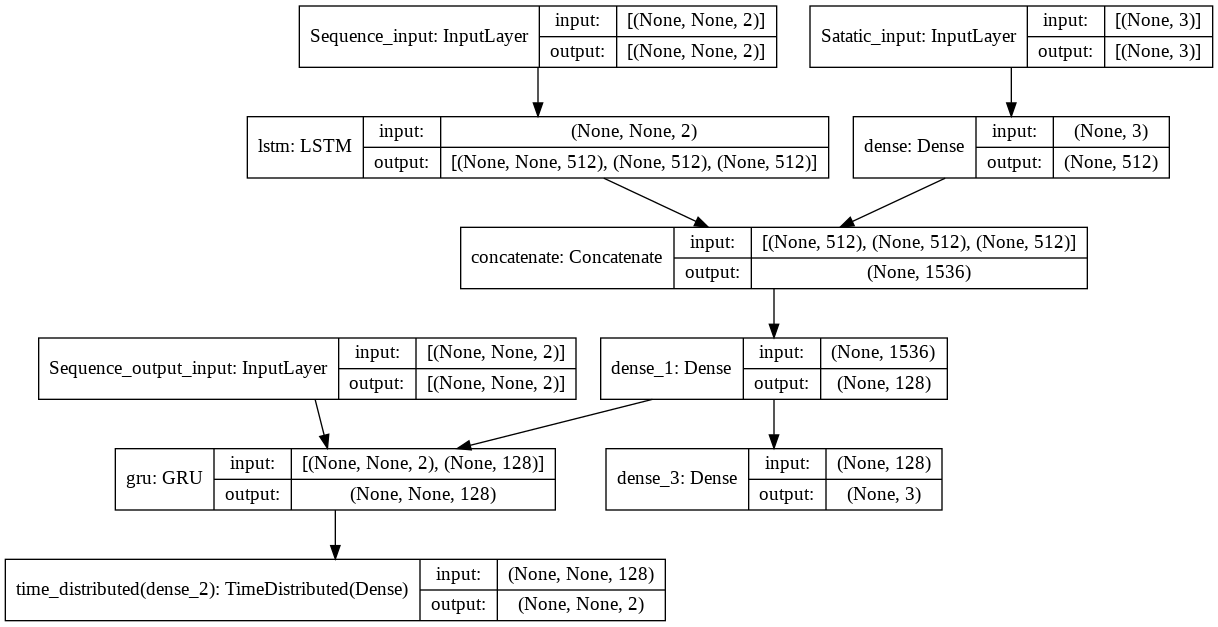

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10)